# Feature Selection

Feature selection on basis of Radiomics Features of AHA segments extracted from phantoms with different patterns and different resolutions.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import scipy.sparse.linalg
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("phantom_data/all_n1_AHAfeatures.csv")
df = df[df.study.str.endswith("52_from_highres") | df.study.str.startswith("resampled_to_density_52")]

In [3]:
lvm_features = [f for f in df.columns.tolist() if (f.startswith("firstorder") or f.startswith("ngtdm") or f.startswith("glcm") or f.startswith("gldm") or f.startswith("glrlm") or f.startswith("glszm"))]

In [4]:
pathology_code = {
    "healthy": 0,
    "patchy_global": 1,
    "mesocardial_global": 2,
    "subendocardial_global": 3,
    "subepicardial_global": 4,
    "transmural_inferolateral": 5
}

In [5]:
df["target"] = df.pattern.replace(pathology_code)
df.loc[df.Segment.isin([7, 8, 9]) & (df.pattern == "transmural_inferolateral"), "target"] = 0       # Segments 7, 8, 9 are actually LGE-free, so should be "healthy"

## LASSO

accuracy: 0.782608695652174


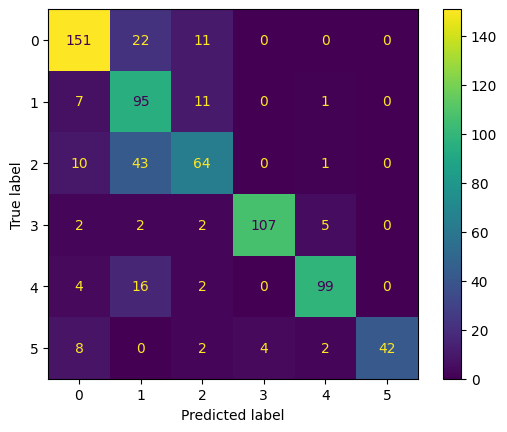

In [6]:
C = 0.01

selected_features = lvm_features # if f not in exclude_features]
id_features = ["study", "Segment", "approx_size", "pattern"]

X = df[id_features + selected_features].values
y = df["target"].values
strat = (df["study"].astype(str) + df["pattern"].astype(str) + df["approx_size"].astype(str))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True, stratify=strat)

scaler = StandardScaler().fit(X_train[:, 4:])
X_scaled_train = scaler.transform(X_train[:, 4:])

# Implement Lasso regression for classification

logreg = LogisticRegression(C=C, penalty="l1", solver="saga", random_state=0, max_iter=50000)
logreg.fit(X_scaled_train, y_train)


# Make predictions
y_pred_lr = logreg.predict(scaler.transform(X_test[:, 4:]))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr)

conf_matrix = confusion_matrix(y_test, y_pred_lr)
print("accuracy:", accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, )
disp.plot()

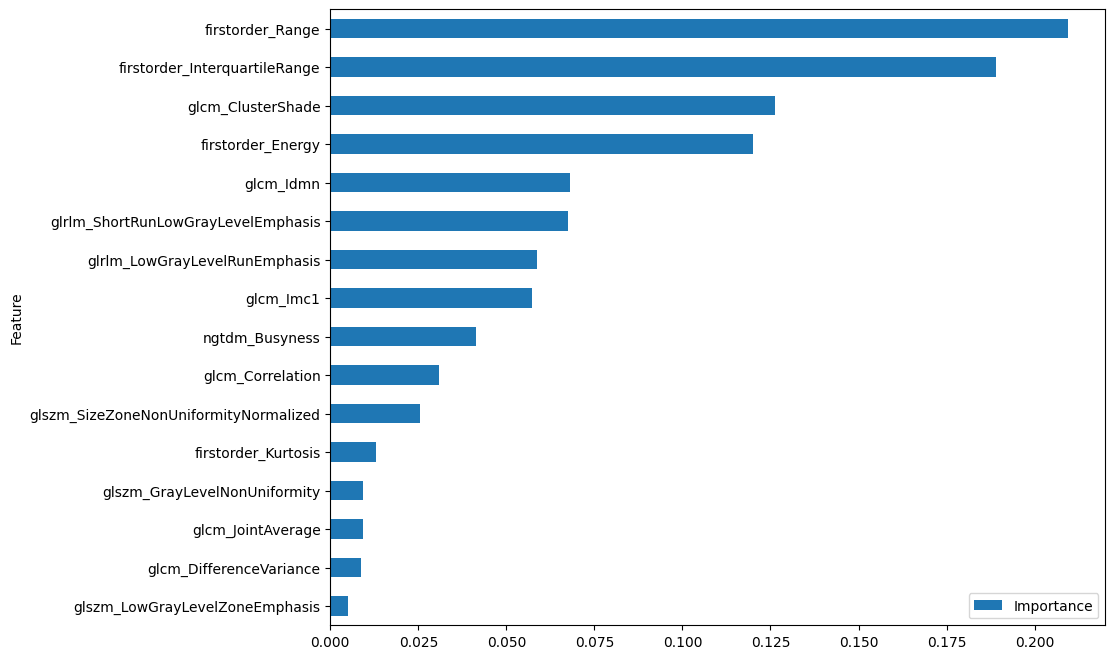

In [7]:
avg_importance = np.mean(np.abs(logreg.coef_), axis=0)
feature_importance = pd.DataFrame({'Feature': selected_features, 'Importance': avg_importance})
feature_importance = feature_importance[feature_importance.Importance > 0].sort_values('Importance', ascending=True)
important_features = feature_importance[feature_importance.Importance > 0]
important_features.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8));

In [8]:
lasso_features = important_features.sort_values(by="Importance", ascending=False).Feature.values.tolist()
lasso_features

['firstorder_Range',
 'firstorder_InterquartileRange',
 'glcm_ClusterShade',
 'firstorder_Energy',
 'glcm_Idmn',
 'glrlm_ShortRunLowGrayLevelEmphasis',
 'glrlm_LowGrayLevelRunEmphasis',
 'glcm_Imc1',
 'ngtdm_Busyness',
 'glcm_Correlation',
 'glszm_SizeZoneNonUniformityNormalized',
 'firstorder_Kurtosis',
 'glszm_GrayLevelNonUniformity',
 'glcm_JointAverage',
 'glcm_DifferenceVariance',
 'glszm_LowGrayLevelZoneEmphasis']

## mRMR

minimum Redundancy, maximum Relevance feature selection, as in [Peng H, Long F, Ding C. Feature Selection Based on Mutual Information: Criteria of Max-Dependency, Max-Relevance, and Min-Redundancy. IEEE Trans Pattern Anal Mach Intell. 2005;27:1226-1238.](https://doi.org/10.1109/TPAMI.2005.159)


Code from https://github.com/fbrundu/pymrmr

In [9]:
import pymrmr

df_test = df[["target"] + selected_features].copy()
df_test.reset_index(inplace=True, drop=True)

# normalise and discretize (below, within and above 1*std, recommended by authors)
sc = StandardScaler()
sc.fit(df_test)
df_test_norm = pd.DataFrame(sc.transform(df_test), columns=df_test.columns.tolist())
df_test_norm["target"] = df_test.target.values
for col in selected_features:
    df_test_norm[col] = pd.cut(x=df_test_norm[col], bins = [-np.inf,-1, 1, np.inf], labels = [-1, 0, 1])

In [10]:
pymrmr_features_mid = pymrmr.mRMR(df_test_norm, 'MID', 16);
pymrmr_features_miq = pymrmr.mRMR(df_test_norm, "MIQ", 16);

In [11]:
pymrmr_features_mid

['firstorder_Maximum',
 'glcm_JointAverage',
 'firstorder_Kurtosis',
 'gldm_GrayLevelVariance',
 'glcm_Idmn',
 'firstorder_Range',
 'firstorder_Median',
 'glcm_DifferenceAverage',
 'glcm_ClusterShade',
 'glcm_Imc1',
 'firstorder_RobustMeanAbsoluteDeviation',
 'firstorder_Mean',
 'glcm_Correlation',
 'glszm_GrayLevelVariance',
 'glrlm_ShortRunLowGrayLevelEmphasis',
 'glcm_DifferenceEntropy']

In [12]:
pymrmr_features_miq

['firstorder_Maximum',
 'glrlm_RunVariance',
 'gldm_HighGrayLevelEmphasis',
 'glcm_Idmn',
 'glcm_Imc1',
 'glrlm_ShortRunLowGrayLevelEmphasis',
 'firstorder_Kurtosis',
 'ngtdm_Complexity',
 'firstorder_TotalEnergy',
 'firstorder_Minimum',
 'firstorder_Range',
 'glcm_JointEntropy',
 'firstorder_Skewness',
 'firstorder_RobustMeanAbsoluteDeviation',
 'ngtdm_Strength',
 'firstorder_Energy']